## Start Time 07.20 PM

## End Timne 09.20 PM

In [298]:
import pandas as pd
import numpy as np


# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [299]:
data = pd.read_csv('training_data.csv')


In [300]:
#Replacing the ? with the NA for all the dataframe
data = data.replace('?', np.NaN)


In [301]:
# Find the misssing column of the dataframe

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [302]:
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 50 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
weight,78844,96.8
medical_specialty,39935,49.1
payer_code,32231,39.6
race,1813,2.2
diag_3,1125,1.4
diag_2,288,0.4
diag_1,18,0.0


In [303]:
print(data.shape)


(81414, 50)


From the above missing value statistic we see that weight has more missing values, we can drop the columns with
high percentage of missing value but we wont know the importance of the column, so we will keep and impute it with median and find its importantce

In [304]:
#Use label encoding for the categorical value of two value and one-hot
#encoding of column values which has more than two values

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)



13 columns were label encoded.


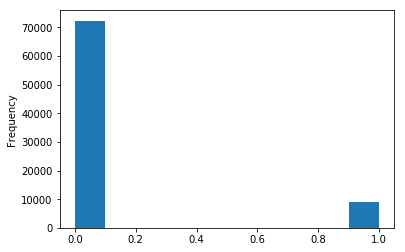

In [305]:
# We will leave the age column as of now 

data['readmitted'].astype(int).plot.hist();


## The data is highly imbalanced, so we will use preciion and recall for evaluating the model

# One hot Encoding 

In [306]:
data  = pd.get_dummies(data)

In [307]:
data.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient',
       ...
       'miglitol_Steady', 'miglitol_Up', 'insulin_Down', 'insulin_No',
       'insulin_Steady', 'insulin_Up', 'glyburide-metformin_Down',
       'glyburide-metformin_No', 'glyburide-metformin_Steady',
       'glyburide-metformin_Up'],
      dtype='object', length=2371)

In [308]:
data.shape

(81414, 2371)

In [309]:
#Get the target variable from the data
from sklearn.model_selection import train_test_split
target = data['readmitted']
data = data.drop(['readmitted'],axis=1)

#Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

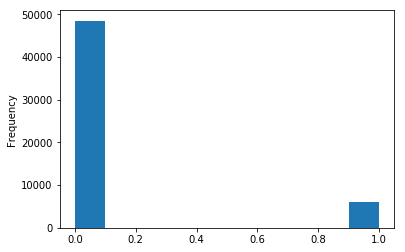

In [310]:
y_train.astype(int).plot.hist();

In [311]:
train_encounter = X_train['encounter_id']


test_encounter = X_test['encounter_id']



In [312]:
X_test = X_test.drop(['encounter_id'],axis=1)
X_train = X_train.drop(['encounter_id'],axis=1)

# Preprocessing 

### Imputation to handle missing data and Scaling the data so that it will be normalized

In [313]:


from sklearn.preprocessing import MinMaxScaler, Imputer


train = X_train.copy()


# Feature names
features = list(train.columns)

# Copy of the testing data
test = X_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (54547, 2369)
Testing data shape:  (26867, 2369)


### Logisitc Regression

We will use logistic regression model to predict the readmittence , the model predicts the given example based on the probability, the model main assumption is the log odd ratio has linear relationship with predictors

In [314]:
#Fitting a baseline logistic regression model along with L2 Regularrization


from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(penalty='l1',C = 0.1,class_weight="balanced")

# Train on the training data
log_reg.fit(train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [315]:
#prediction

predictions_lr = log_reg.predict_proba(test)[:,1]

#Since we have high class imbalance problem we will set different threshold for classification and check precision 
#and recall for them
predictions_lr_y =[1 if i>0.5 else 0 for i in predictions_lr]

predictions_lr_y_9 =[1 if i>0.9 else 0 for i in predictions_lr]
predictions_lr_y_7 =[1 if i>0.7 else 0 for i in predictions_lr]
predictions_lr_y_5 =[1 if i>0.5 else 0 for i in predictions_lr]
predictions_lr_y_3 =[1 if i>0.3 else 0 for i in predictions_lr]
predictions_lr_y_15 =[1 if i>0.15 else 0 for i in predictions_lr]

print()
print("The probability values of the test data of training")
print(log_reg.predict_proba(test)[:,1])

score_lr = log_reg.score(test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(score_lr))




The probability values of the test data of training
[0.31996478 0.62416216 0.39112994 ... 0.35289646 0.34872148 0.36571673]
Accuracy of logistic regression classifier on test set: 0.66


In [316]:
import matplotlib.pyplot as plt
from sklearn import metrics
cm_9 = metrics.confusion_matrix(y_test, predictions_lr_y_9)
cm_7 = metrics.confusion_matrix(y_test, predictions_lr_y_7)
cm_5 = metrics.confusion_matrix(y_test, predictions_lr_y_5)
cm_3 = metrics.confusion_matrix(y_test, predictions_lr_y_3)
cm_15 = metrics.confusion_matrix(y_test, predictions_lr_y_15)

print("The positive and negative in the test data")
print(y_test.value_counts())
print()
print("The confusion matrix with threshold 0.9")
print(cm_9)
print()
print("The confusion matrix with threshold 0.7")
print(cm_7)
print()
print("The confusion matrix with threshold 0.5")
print(cm_5)
print()
print("The confusion matrix with threshold 0.3")
print(cm_3)
print()
print("The confusion matrix with threshold 0.15")

print(cm_15)


The positive and negative in the test data
0    23853
1     3014
Name: readmitted, dtype: int64

The confusion matrix with threshold 0.9
[[23811    42]
 [ 2970    44]]

The confusion matrix with threshold 0.7
[[22905   948]
 [ 2641   373]]

The confusion matrix with threshold 0.5
[[16058  7795]
 [ 1392  1622]]

The confusion matrix with threshold 0.3
[[ 1420 22433]
 [   64  2950]]

The confusion matrix with threshold 0.15
[[    1 23852]
 [    0  3014]]


#### The threshold 0.15 of classification threshold gives high recall/sensitivity, predicts everything as positive (denoting readmittence)

#### The treshold 0.9 of classification threshold gives high precision, predicts  the given patient readmittence only if we are 90% sure that the patient will be readmitted.

#### The accuracy of 0.5 probability model is 0.66

#### We have L1 Regularization with 0.1 as regularization parameter

In [317]:
y_test.value_counts()

0    23853
1     3014
Name: readmitted, dtype: int64

In [318]:
#Using Precision, recall, F1 as evaluation metric of the model
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_lr_y))

             precision    recall  f1-score   support

          0       0.92      0.67      0.78     23853
          1       0.17      0.54      0.26      3014

avg / total       0.84      0.66      0.72     26867



# Advanced Model : RandomForest

In [319]:
#Improved Model
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(random_state = 42,class_weight="balanced")

In [320]:
random_forest.fit(train, y_train)

#make predicition
pred_y = random_forest.predict(test)


In [321]:
score = random_forest.score(test, y_test)
print("Accuracy of baseline model {}.".format(score))

Accuracy of baseline model 0.8876316671009045.


In [322]:

import matplotlib.pyplot as plt
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_y)
print(cm)

[[23818    35]
 [ 2984    30]]


In [323]:
print(classification_report(y_test, pred_y))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     23853
          1       0.46      0.01      0.02      3014

avg / total       0.84      0.89      0.84     26867



## Important Features

#### Let us find the important features


In [324]:
#Plotting important features

def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized (0 - 1)'); plt.title('Feature Importances')
    plt.show()
    
    return df

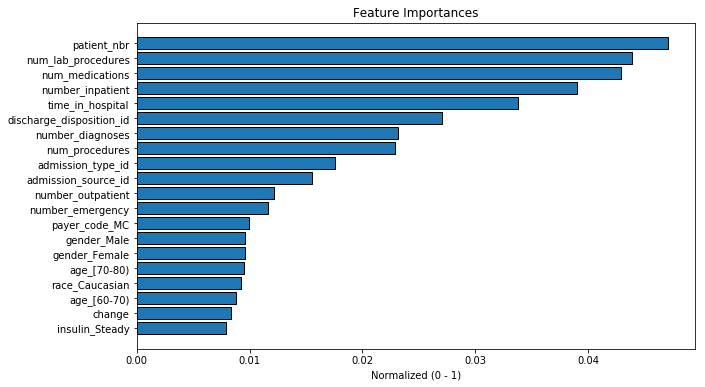

In [325]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)

### Some of the important features which helps in predicting readmittence are

 + Patient_nbr,
 + num_lab_procedures
 + num_medication
 + number_inpatient
 + time_in_hospoitals

# Parameters of the improved model

In [326]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(random_forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## ROC and AUC for Logistic Regression and RandomForest

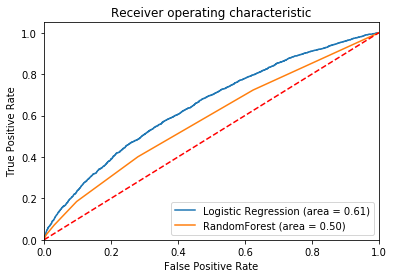

In [327]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#FPR and TPR from logistic regression
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(test))
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, log_reg.predict_proba(test)[:,1])

#FPR and TPR from base randomForestClassifier
base_random_roc_auc = roc_auc_score(y_test, random_forest.predict(test))
fpr_base_rf, tpr_base_rf, thresholds_base_rf = roc_curve(y_test, random_forest.predict_proba(test)[:,1])


plt.figure()

plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_base_rf, tpr_base_rf, label='RandomForest (area = %0.2f)' % base_random_roc_auc)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## The Logistic Regression seems to be good model than RandomForest Classifier. 

## The above RoC of logistic regression model is of 0.5 threshold prediction.

## If we want the business use case to predict a given patient as readmittence only if we are very confident then we need to increase the probability threshold of logistic regression to be 0.9 .

## If we want to avoid missing many cases of readmittance we need to increase the recall so we need to set the probability threshold like 0.15

## We will choose probability of 0.5, as it gives good accuracy and descent precision and recall

In [328]:
#Test data prediction

testing = pd.read_csv("test_data.csv")

testing = testing.replace('?', np.NaN)

print(testing.shape)
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in testing:
    if testing[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(testing[col].unique())) <= 2:
            # Train on the training data
            le.fit(testing[col])
            # Transform both training and testing data
            testing[col] = le.transform(testing[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

print(testing.shape)

(20352, 49)
12 columns were label encoded.
(20352, 49)


In [329]:
testing  = pd.get_dummies(testing)

In [331]:
#Get the encounter_id and patient_nbr
testing_encounter = testing['encounter_id']
testing = testing.drop(['encounter_id'],axis=1)

In [332]:
X_train.columns

Index(['patient_nbr', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency',
       ...
       'miglitol_Steady', 'miglitol_Up', 'insulin_Down', 'insulin_No',
       'insulin_Steady', 'insulin_Up', 'glyburide-metformin_Down',
       'glyburide-metformin_No', 'glyburide-metformin_Steady',
       'glyburide-metformin_Up'],
      dtype='object', length=2369)

In [334]:
#manage Mis-match shape of testing data to data used for model creation
missing_cols = set( X_train.columns ) - set( testing.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    
    testing[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
testing = testing[X_train.columns]

In [336]:
#We will impute and scale testing data simillar way 
testing = imputer.transform(testing)

testing = scaler.transform(testing)

In [337]:
#Get prediction value of the testing data
testing_score = log_reg.predict_proba(testing)[:,1]

In [339]:
#Create pandas dataframe for encounter_id and score 

test_output_list = list(zip(testing_encounter,testing_score))

test_op = pd.DataFrame(test_output_list,columns=['encounter_id','predicted_probability'])

test_op.to_csv('herle_syam.csv', sep=',', encoding='utf-8',index=False)